# II. Programming
## Consider the diabetes.arff data available at the homework tab, comprising 8 biological features to classify 768 patients into 2 classes (normal, diabetes). 

In [16]:
# General imports
import pandas as pd
from scipy.io import arff
import plotly.express as px
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
diabetes_data, diabetes_metadata = arff.loadarff('diabetes.arff')
df = pd.DataFrame(diabetes_data)

### Visualizing and preprocessing

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'1'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'0'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'1'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'0'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'1'


In [4]:
df['Outcome'] = df['Outcome'].apply(lambda x: int(x))

In [14]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


### 1. [1v] ANOVA is a statistical test that can be used to assess the discriminative power of a single input variable. Using f_classif from sklearn, identify the input variables with the worst and best discriminative power. Plot their class-conditional probability density functions.

In [34]:
# Imports
from sklearn import feature_selection as fs
from scipy.stats import norm
import numpy as np

In [6]:
f_stats, p_values = fs.f_classif(df.drop('Outcome', axis=1), df['Outcome'])

In [14]:
fig = px.scatter(x=df.columns[:-1], y=f_stats, labels={'x': 'Feature', 'y': 'F Statistic', 'color': 'p-values'}, color=p_values, title='F-value for each feature')
fig.update_traces(marker_size=15)

The F Statistic, one of the metrics given by ```f_classif```, is a ratio between the variance between groups and the variance within groups. Essentially, it translates how much of the variance is due to differences between different groups in the data - here, the groups are specified by the target class of each entry/data point.

$$\text{F-value} = \frac{\text{between groups variance}}{\text{within groups variance}}$$

As this is the case, the variable which shows the highest F statistic should hold the largest (and, therefore, best) discriminative power, and vice-versa for the variable with the lowest discriminative power.

We conclude, therefore, that the variable with the...
- **best** discriminative power is ```'Glucose'```, with an F-value of _213.1618_    (p-value: _8.9E-43_).
- **worst** discriminative power is ```'BloodPressure'```, with an F-value of _3.25695_    (p-value: _0.071_).

The higher the p-value, the more confidently we can accept the null hypothesis that the means of the variable are the same across all classes. Here, the p-values further support what the F-values are showing.

In [31]:
# Empirical (unsure whether to do this or to use a gaussian maximum likelihood estimate, since the variables are numerical)

def empirical_pdf_class(variable, df):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'Empirical PDF for {variable}')
    for target_val in [0,1]:
        data = df[df['Outcome'] == target_val][variable]
        axs[target_val].hist(data, bins=int(max(df[variable])), alpha=0.5, density=True)
        axs[target_val].set_title(f'Empirical distribution for class {target_val}')
        axs[target_val].set_xlabel(variable)
        axs[target_val].set_ylabel('Probability')
    return fig
    

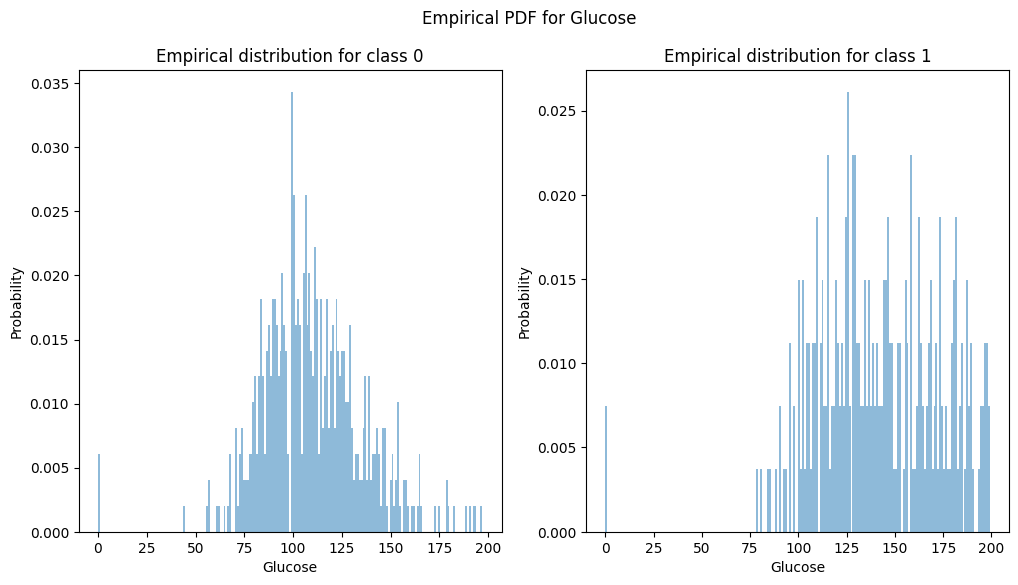

In [32]:
glucose_pdf = empirical_pdf_class('Glucose', df)

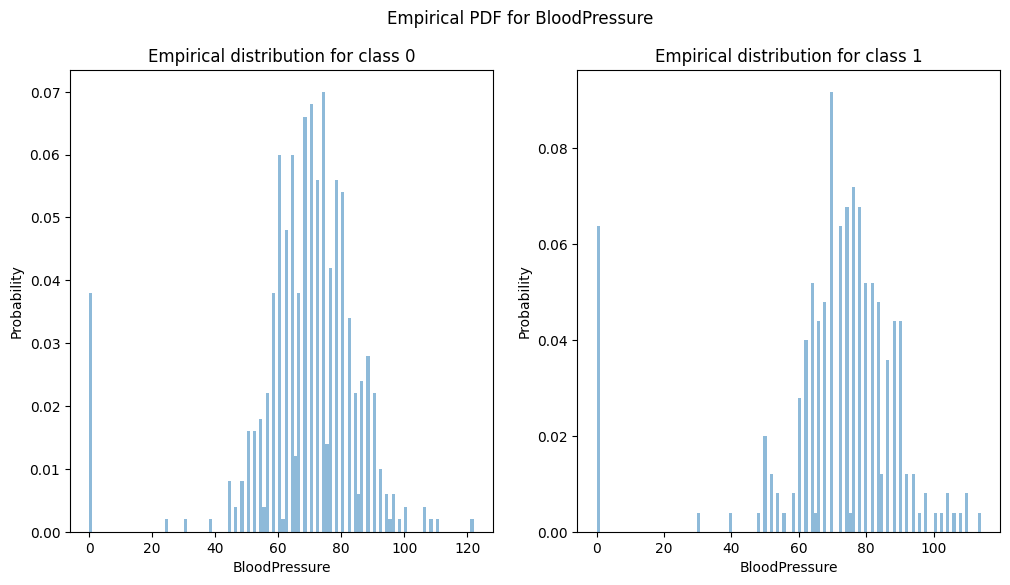

In [28]:
blood_pressure_pdf = empirical_pdf_class('BloodPressure', df)

In [69]:
# Gaussian MLE
def mle_pdf_class(variable, df):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f'MLE PDF for {variable}')
    for target_val in [0,1]:
        data = df[df['Outcome'] == target_val][variable]
        mu, std = norm.fit(data)
        inf, sup = min(data), max(data) # x axis limits
        x_vals = np.linspace(inf, sup, 200)
        axs[target_val].plot(x_vals, norm.pdf(x_vals, mu, std))
        axs[target_val].axvline(mu, color='r', linestyle='--', label='Mean')
        axs[target_val].annotate(f'μ = {mu:.2f}\nσ = {std:.2f}',
                                 xy=(0,0),
                                 xytext=(0.1,0.2),
                                 xycoords='axes fraction')
        axs[target_val].set_title(f'MLE Gaussian distribution for class {target_val}')
        axs[target_val].set_xlabel(variable)
        axs[target_val].set_ylabel('Probability')
        
    return fig

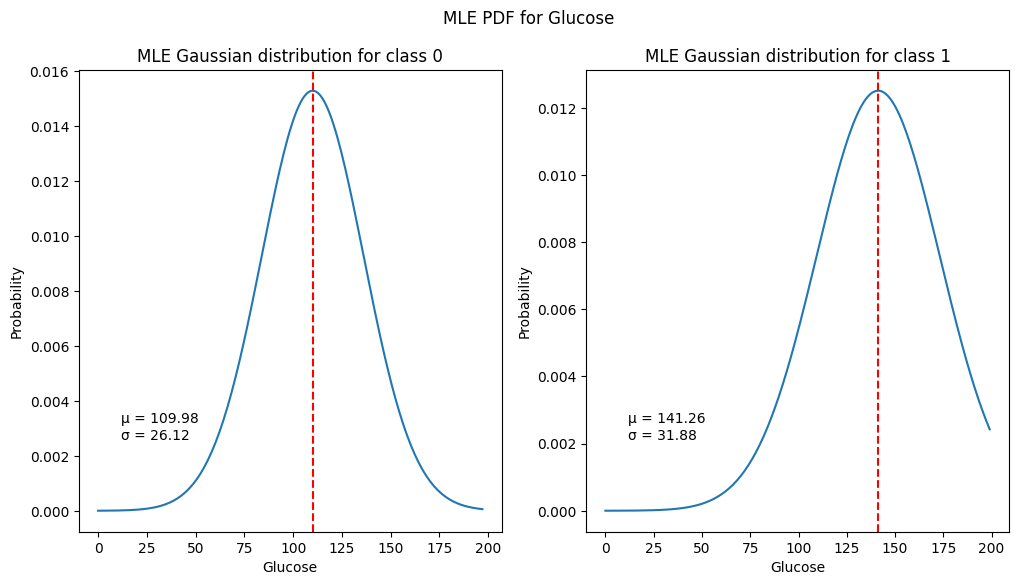

In [70]:
glucose_mle_pdf = mle_pdf_class('Glucose', df)

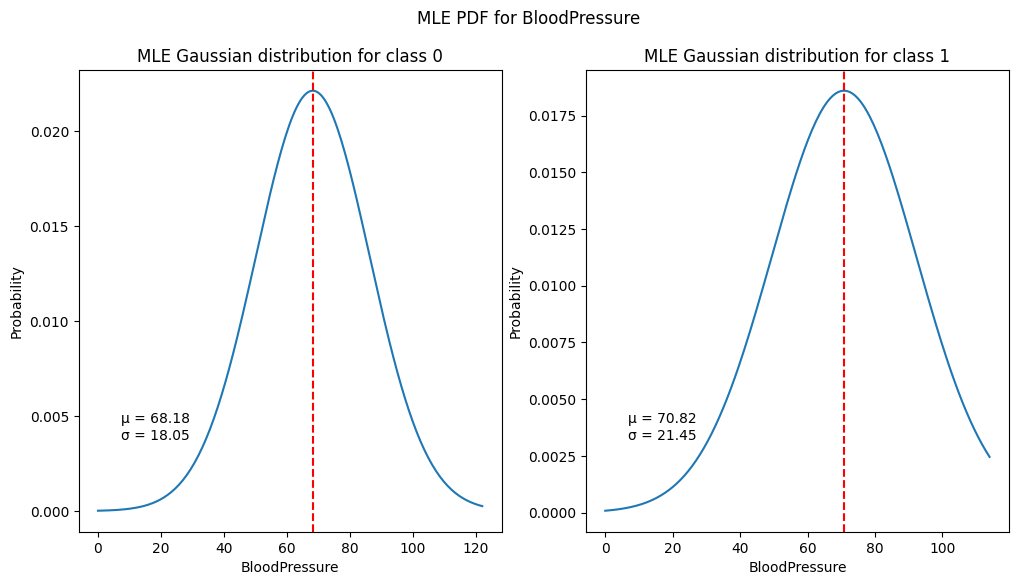

In [71]:
blood_pressure_mle_pdf = mle_pdf_class('BloodPressure', df)

### 2) [4v] Using a stratified 80-20 training-testing split with a fixed seed (random_state=1), assess in a single plot both the training and testing accuracies of a decision tree with minimum sample split in {2,5,10,20,30,50,100} and the remaining parameters as default.  

[optional] Note that split thresholding of numeric variables in decision trees is non-
deterministic in sklearn, hence you may opt to average the results using 10 runs per 
parameterization.

In [98]:
# Imports

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier

In [129]:
# Train-test split

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
train_inds, test_inds = next(stratified_splitter.split(np.zeros(len(df)), df['Outcome']))


X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train = X.iloc[train_inds]
y_train = y.iloc[train_inds]
X_test = X.iloc[test_inds]
y_test = y.iloc[test_inds]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [132]:
min_sample_splits = [2,5,10,20,30,50,100]
train_accuracies = []
test_accuracies = []

def fitted_tree_classifier(X_train, y_train, min_samples_split):
    tree = DecisionTreeClassifier(min_samples_split=min_samples_split)
    return tree.fit(X_train, y_train)

for min_samples_split in min_sample_splits:
    train_accuracies_temp = []
    test_accuracies_temp = []
    for i in range(10):
        tree = fitted_tree_classifier(X_train, y_train, min_samples_split)
        train_accuracies_temp.append(tree.score(X_train, y_train))
        test_accuracies_temp.append(tree.score(X_test, y_test))
    print(test_accuracies_temp)
    train_accuracies.append(np.mean(train_accuracies_temp))
    test_accuracies.append(np.mean(test_accuracies_temp))


    

[0.6883116883116883, 0.6753246753246753, 0.7012987012987013, 0.7077922077922078, 0.7012987012987013, 0.7077922077922078, 0.7272727272727273, 0.7077922077922078, 0.7077922077922078, 0.7012987012987013]
[0.7012987012987013, 0.6948051948051948, 0.6948051948051948, 0.7077922077922078, 0.7077922077922078, 0.6948051948051948, 0.6948051948051948, 0.6948051948051948, 0.6883116883116883, 0.7142857142857143]
[0.6948051948051948, 0.6948051948051948, 0.7337662337662337, 0.7012987012987013, 0.7012987012987013, 0.7272727272727273, 0.7142857142857143, 0.7337662337662337, 0.7142857142857143, 0.7142857142857143]
[0.7597402597402597, 0.7597402597402597, 0.7402597402597403, 0.7597402597402597, 0.7597402597402597, 0.7402597402597403, 0.7532467532467533, 0.7532467532467533, 0.7532467532467533, 0.7337662337662337]
[0.7467532467532467, 0.7467532467532467, 0.7662337662337663, 0.7467532467532467, 0.7662337662337663, 0.7662337662337663, 0.7467532467532467, 0.7662337662337663, 0.7467532467532467, 0.7662337662337